# 제품 review 데이터의 감성 분석

사용한 데이터 :amazon_uk_shoes_products_dataset_2021_12.csv

데이터 로드

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

data = pd.read_csv('./amazon_uk_shoes_products_dataset_2021_12.csv')

데이터 프레임의 모양을 프린트

In [4]:
print("The shape of the data (rows, cols) is " + str(data.shape))

The shape of the data (rows, cols) is (6823, 11)


### 데이터 탐색


In [5]:
# 데이터 프레임의 기본 정보 확인
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB
None


In [6]:
# 데이터의 처음 몇 행 확인
print(data.head())

                                      url  \
0  https://www.amazon.co.uk/dp/B07SBX32T5   
1  https://www.amazon.co.uk/dp/B07SBX32T5   
2  https://www.amazon.co.uk/dp/B07SBX32T5   
3  https://www.amazon.co.uk/dp/B07SBX32T5   
4  https://www.amazon.co.uk/dp/B08SW434MG   

                                        product_name     reviewer_name  \
0  Klasified Women's Transparent Clear Sneaker Sh...  Jocelyn McSayles   
1  Klasified Women's Transparent Clear Sneaker Sh...      Kenia Rivera   
2  Klasified Women's Transparent Clear Sneaker Sh...       Chris Souza   
3  Klasified Women's Transparent Clear Sneaker Sh...   Amazon Customer   
4  GUESS Women's Bradly Gymnastics Shoe, White, 7 UK         Graziella   

         review_title                                        review_text  \
0             Love em  Love these. Was looking for converses and thes...   
1  The plastic ripped  The shoes are very cute, but after the 2nd day...   
2        Good quality                                   

In [7]:
# 기술 통계 확인
print(data.describe())

       review_rating
count    6823.000000
mean        4.132493
std         1.336969
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000


### 데이터 정리

결측값 처리

In [8]:
# 결측값 제거
data = data.dropna(subset=['review_title', 'review_text', 'helpful_count'])

##### 노이즈 제거

In [9]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)  # 1사분위수
    Q3 = data[column].quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1  # 사분위수 범위
    lower_bound = Q1 - 1.5 * IQR  # 하한값
    upper_bound = Q3 + 1.5 * IQR  # 상한값
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

# 'review_rating' 열에서 이상치 제거
data = remove_outliers(data, 'review_rating')


##### 소문자 변환, 불용어 제거, 특수 문자 제거 등

In [13]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# NLTK 리소스 다운로드
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 불용어 설정
stop_words = set(stopwords.words('english'))

# 스테머 및 표제어 추출기 설정
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, method='lemmatization'):
    # 소문자 변환
    text = text.lower()
    # 특수 문자 제거
    text = re.sub(f"[{string.punctuation}]", "", text)
    # 단어 토큰화
    words = word_tokenize(text)
    # 불용어 제거
    words = [word for word in words if word not in stop_words]
    
    if method == 'stemming':
        # 스테밍
        words = [stemmer.stem(word) for word in words]
    elif method == 'lemmatization':
        # 표제어 추출
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return " ".join(words)

# 전처리 과정 적용
data['cleaned_review_text'] = data['review_text'].apply(lambda x: preprocess_text(x, method='lemmatization'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


리뷰 평점을 기반으로 감성 레이블을 생성합니다. 
평점 1-2는 부정, 4-5는 긍정, 3은 중립으로 설정하였습니다.

In [15]:
def sentiment_label(rating):
    if rating <= 2:
        return -1  # negative
    elif rating == 3:
        return 0  # neutral
    else:
        return 1  # positive

data['sentiment'] = data['review_rating'].apply(sentiment_label)


데이터를 학습용과 테스트용으로 나눕니다.

In [16]:
from sklearn.model_selection import train_test_split

X = data['cleaned_review_text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 모델 학습 및 튜닝

Logistic Regression

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Logistic Regression 모델 파이프라인
lr_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=200))
])

# 하이퍼파라미터 그리드 설정
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'vect__max_df': [0.8, 0.9, 1.0],
    'vect__ngram_range': [(1, 1), (1, 2)]
}
# 그리드 서치 설정
grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='accuracy')

# 모델 학습
grid_search_lr.fit(X_train, y_train)

# 최적의 파라미터와 모델
best_lr_model = grid_search_lr.best_estimator_
print("Best Logistic Regression parameters:", grid_search_lr.best_params_)

Best Logistic Regression parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'vect__max_df': 0.8, 'vect__ngram_range': (1, 1)}


교차 검증을 사용하여 모델의 견고성을 확인

In [ ]:
from sklearn.model_selection import cross_val_score

# Logistic Regression 모델의 교차 검증
lr_cv_scores = cross_val_score(best_lr_model, X_train, y_train, cv=5, scoring='accuracy')

print("Logistic Regression Cross Validation Scores:")
print(lr_cv_scores)
print("Mean Accuracy:", lr_cv_scores.mean())


Logistic Regression Cross Validation Scores:
[0.81851512 0.81743119 0.82385321 0.82018349 0.79357798]
Mean Accuracy: 0.8147121990598644


#### 모델 평가

Logistic Regression 평가

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 예측
lr_predictions = best_lr_model.predict(X_test)

# 평가
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))
print("Accuracy:", accuracy_score(y_test, lr_predictions))

# 혼동 행렬
lr_cm = confusion_matrix(y_test, lr_predictions)
print("Confusion Matrix:")
print(lr_cm)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.69      0.57      0.62        88
           0       0.25      0.07      0.12        40
           1       0.80      0.94      0.86       262

    accuracy                           0.76       390
   macro avg       0.58      0.53      0.53       390
weighted avg       0.72      0.76      0.73       390

Accuracy: 0.764102564102564
Confusion Matrix:
[[ 50   5  33]
 [  9   3  28]
 [ 13   4 245]]


#### 결과 시각화 및 보고

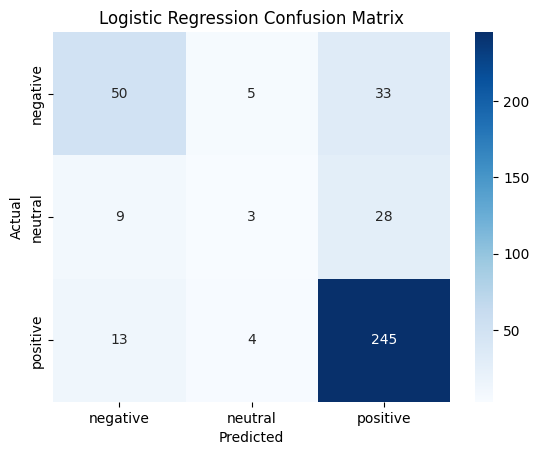

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['negative', 'neutral', 'positive'],
                   yticklabels=['negative', 'neutral', 'positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Logistic Regression 혼동 행렬 시각화
plot_confusion_matrix(lr_cm, "Logistic Regression Confusion Matrix")
